# Forseen steps for successful alignment

1. Record both pixel size and pixel dimensions of trajectory videos and cell tilescans.
2. Load xy points of trajectory videos within cell tilescan.
3. Cut out region in cell tilescan image corresponding to trajectory video.
4. Convert cell tilescan image to pixel dimensions of trajectory video (2048 x 2048).
5. Extract cell features.

In [18]:
from diff_classifier import features as ft
from diff_classifier import heatmaps as hm
from diff_register import im_process as imp
from diff_classifier import aws
import pandas as pd
import skimage.io as sio
from skimage import transform as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import xml.etree.ElementTree as et

# Record both pixel size and pixel dimensions of trajectory videos and cell tilescans.

In [6]:
#Input parameters. Pixel ratios of input cell tilescales and trajectory vidoes (units of microns per pixel) and image
#dimensions in pixels.

pxrat_cells = 0.62
pxrat_traj = 0.18

dim_traj = 2048
dim_cells = int(np.round(dim_traj*pxrat_traj/pxrat_cells, decimals=0))

In [7]:
dim_cells

595

In [8]:
xmlfile = 'multipoints_S2.xml'

def read_xmlpoints(xmlfile, converttopix = True, umppx=0.62, offset=(17000, -1460)):
    """
    Parameters
    ----------
    
    xmlfile: XML file containing locations at which trajectory videos were collected.
    converttopix: User indicates whether points should be converted to pixels within
        the cell tilescan image, or remain in microns.
    umppx: microns per pixel. Pixel density of cell tilescan image.
    offset: 
    
    """
    tree = et.parse(xmlfile)
    root = tree.getroot()

    y = []
    x = []
    xmlpoints = []
    counter = 0
    
    for point in root[0]:
        if counter > 1:
            x = float(point[2].attrib['value'])
            y = float(point[3].attrib['value'])
            if converttopix:
                xmlpoints.append(((x-offset[0])/umppx,(y-offset[1])/umppx))
            else:
                xmlpoints.append((x, y))
        counter = counter + 1

    return xmlpoints

# Load xy points of trajectory videos within cell tilescan.

In [11]:
xmlpoints = read_xmlpoints(xmlfile, converttopix=False)

In [12]:
cprefix = 'S1_NUC'
cfile = '{}.tif'.format(cprefix)
cfolder = 'Tissue_Studies/04_23_18_Registration_Test'

cin = sio.imread(cfile)

In [13]:
def crop_to_videodims(cell_image, multichannel = False, vidpoint=(600, 600), defaultdims=True, dim=512, save=True,
                      fname='test.tif'):
    
    if defaultdims:
        ndim = 512
    else:
        ndim = dim

    if not multichannel:
        subim = cell_image[int(vidpoint[0]-ndim/2):int(vidpoint[0]+ndim/2), int(vidpoint[1]-ndim/2):int(vidpoint[1]+ndim/2)]

    if save:
        sio.imsave(fname, subim)
        
    return subim

# Cut out region in cell tilescan image corresponding to trajectory video.

In [14]:
prefix = 'DAPI'
cell_orig = '{}.tif'.format(prefix)
cell_bin = 'clean_{}.png'.format(prefix)
cell_cut = 'short_{}'.format(cell_bin)
call_skel = 'skel_{}'.format(cell_cut)

subim = crop_to_videodims(cin, vidpoint=(10000, 12000), defaultdims=False, dim=dim_cells, fname=cell_orig)

(-0.5, 594.5, 594.5, -0.5)

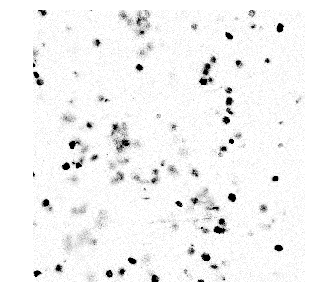

In [16]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(subim, cmap='binary')
plt.axis('off')

# Convert cell tilescan image to pixel dimensions of trajectory video (2048 x 2048).

In [19]:
subim_new = tf.resize(subim, (dim_traj, dim_traj))

/home/ubuntu/miniconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(-0.5, 2047.5, 2047.5, -0.5)

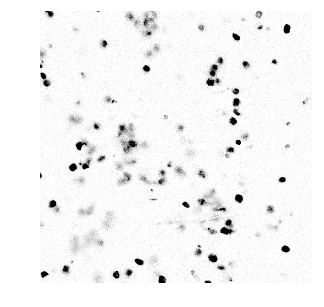

In [20]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(subim_new, cmap='binary')
plt.axis('off')

In [21]:
subim_new.shape

(2048, 2048)